In [1]:
!nvidia-smi

Fri Mar 14 18:40:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   58C    P8             15W /  150W |     670MiB /  16384MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.4.1


'cuda'

# Imports and Constants

In [3]:
import os
import requests
import zipfile
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
import torchinfo
import torchmetrics

In [14]:
BATCH_SIZE = 32
data_dir = "../inputs/"
NUUM_WORKERS = int((os.cpu_count() + 1) / 2)

data_path = Path(data_dir)
image_path = data_path / "pizza_steak_sushi"

# Data Setup & EDA

In [9]:
# Setup path to data folder
data_path = Path(data_dir)
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find ../inputs/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

pizza_train_dir = train_dir / "pizza"
steak_train_dir = train_dir / "steak"
sushi_train_dir = train_dir / "sushi"

In [7]:
walk_through_dir(train_dir)

There are 3 directories and 0 images in '../inputs/pizza_steak_sushi/train'.
There are 0 directories and 72 images in '../inputs/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in '../inputs/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in '../inputs/pizza_steak_sushi/train/pizza'.


In [8]:
imag_path_list = list(image_path.glob('*/*/*.jpg'))

In [9]:
train_img_paths = list(train_dir.glob("*/*.jpg"))

In [10]:
random.sample(imag_path_list, k=10)

[PosixPath('../inputs/pizza_steak_sushi/train/steak/443210.jpg'),
 PosixPath('../inputs/pizza_steak_sushi/test/pizza/195160.jpg'),
 PosixPath('../inputs/pizza_steak_sushi/train/sushi/843815.jpg'),
 PosixPath('../inputs/pizza_steak_sushi/train/sushi/2590819.jpg'),
 PosixPath('../inputs/pizza_steak_sushi/train/sushi/377047.jpg'),
 PosixPath('../inputs/pizza_steak_sushi/train/pizza/29417.jpg'),
 PosixPath('../inputs/pizza_steak_sushi/test/pizza/3475871.jpg'),
 PosixPath('../inputs/pizza_steak_sushi/train/pizza/3505182.jpg'),
 PosixPath('../inputs/pizza_steak_sushi/train/pizza/2800325.jpg'),
 PosixPath('../inputs/pizza_steak_sushi/test/pizza/2236338.jpg')]

In [15]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(),
    transforms.GaussianBlur(kernel_size=3, sigma=0.1),
    transforms.ToTensor()
])

In [17]:
def plot_transformed_imgs(file_path, transform, k=10):
    """
    """
    if k>10:
        k=10
        print("Max 10 images to be shown!")
    random.seed(42)
    random_img_paths = random.sample(file_path, k=k)

    for img_path in random_img_paths:
        with Image.open(img_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Org Size: {f.size}")
            ax[0].axis("off")
            
            t_img = transform(f)
            t_img = torch.permute(t_img, (1,2,0))
            ax[1].imshow(t_img)
            ax[1].set_title(f"Org Size: {t_img.shape}")
            ax[1].axis("off")
            fig.suptitle(f"class: {img_path.parent.stem}", fontsize=16)

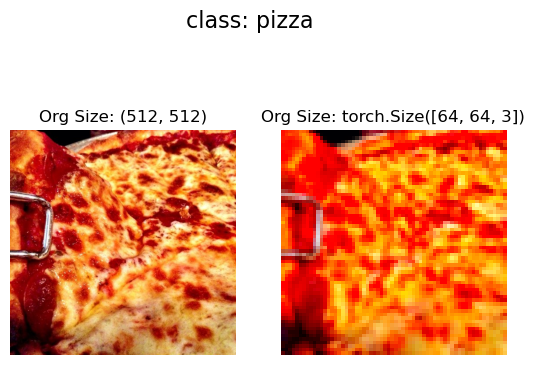

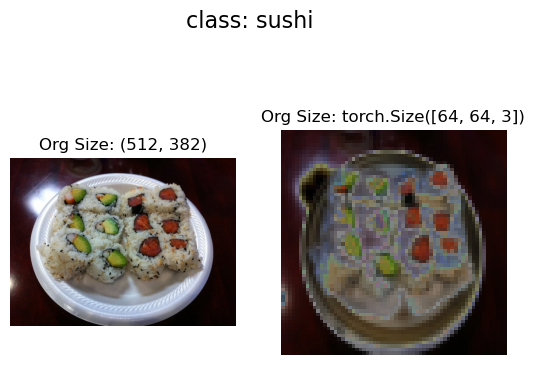

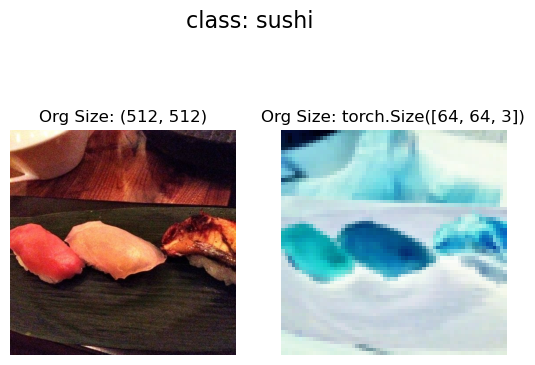

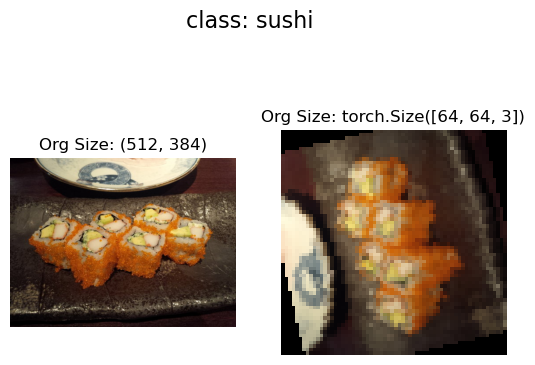

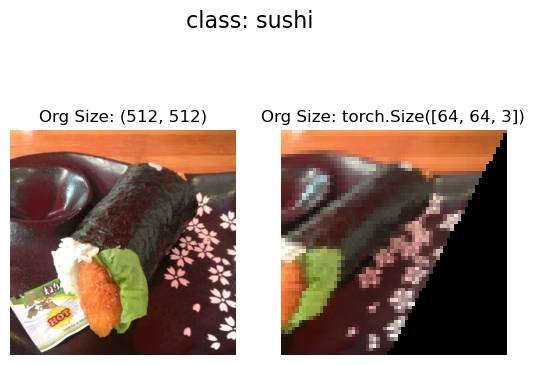

In [18]:
plot_transformed_imgs(imag_path_list, data_transform, k=5)

In [19]:
train_data = ImageFolder(train_dir, transform=data_transform, target_transform=None)
test_data = ImageFolder(test_dir, transform=None, target_transform=None)

In [20]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [21]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUUM_WORKERS)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
len(train_dataloader), len(test_dataloader)

(8, 3)

In [22]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape

torch.Size([32, 3, 64, 64])

In [23]:
single_image = image_batch[0].unsqueeze(dim=0)
single_label = label_batch[0]
single_image.shape, single_label

(torch.Size([1, 3, 64, 64]), tensor(0))

In [24]:
input_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            # nn.MaxPool2d(kernel_size=2)
        )

In [25]:
input_layer(single_image).shape

torch.Size([1, 10, 64, 64])

In [26]:
class tinyVGG(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_layers):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_layers, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layers, out_channels=hidden_layers, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers, out_channels=hidden_layers, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layers, out_channels=hidden_layers, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.dense_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(hidden_layers*16*16), out_features=out_channels)
        )

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.dense_layer(x)
        return x
        

In [27]:
model_0 = tinyVGG(3, len(train_data.classes), 10).to(device)

In [28]:
model_0.parameters, model_0.state_dict

(<bound method Module.parameters of tinyVGG(
   (input_layer): Sequential(
     (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (hidden_layer): Sequential(
     (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (dense_layer): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=2560, out_features=3, bias=True)
   )
 )>,
 <bound method Module.state_dict of tinyVGG(
   (input_layer): Sequential(
     (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel

In [70]:
model_0.eval()
with torch.inference_mode():
    pred_batch = model_0(image_batch.to(device))

In [93]:
y_pred_batch = torch.argmax(torch.softmax(pred_batch, dim=1), dim=1).to(device)

In [96]:
label_batch = label_batch.to(device)

In [100]:
(y_pred_batch == label_batch).sum().item() / len(y_pred_batch)

0.59375

In [30]:
train_data.class_to_idx,torch.argmax(pred).item()

({'pizza': 0, 'steak': 1, 'sushi': 2}, 1)

In [31]:
torchinfo.summary(model_0, single_image.shape)

Layer (type:depth-idx)                   Output Shape              Param #
tinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [104]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
              acc_fn: torchmetrics.metric.Metric=None):
  
    # Put the model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader and data batches
    for X, y in dataloader:
        # Send data to target device
        X = X.to(device)
        y = y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        if acc_fn is not None:
                acc = acc_fn(y_pred, y)
        else:
            y_pred_probs = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            acc = (y_pred_probs == y).sum().item() / len(y)
        train_loss+=loss
        train_acc+=acc
        # 3. Optimizer zero grad 
        optimizer.zero_grad()
        
        # 4. Loss backward 
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
    
    # Calculate and accumualte accuracy metric across all batches
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    # Adjust metrics to get average loss and average accuracy per batch
    return train_loss, train_acc

In [105]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, acc_fn: torchmetrics.metric.Metric=None):
  
    # Put model in eval mode
    model.eval()
    
    # Setup the test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        
        # Loop through DataLoader batches
        for X, y in dataloader:
            # Send data to target device
            X = X.to(device)
            y = y.to(device)
            # 1. Forward pass
            y_pred = model(X)
            
            # 2. Calculuate and accumulate loss
            loss = loss_fn(y_pred, y)
            if acc_fn is not None:
                acc = acc_fn(y_pred, y)
            else:
                y_pred_probs = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                acc = (y_pred_probs == y).sum().item() / len(y)
            
            # Calculate and accumulate accuracy
            test_loss += loss
            test_acc += acc
    
    # Adjust metrics to get average loss and accuracy per batch
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    return test_loss, test_acc

In [114]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
                    acc_fn: torchmetrics.metric.Metric=None,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
    # Create results dictionary
    results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
    
    # Loop through the training and testing steps for a number of epochs
    for epoch in range(epochs):
        # Train step
        train_loss, train_acc = train_step(model=model, 
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn, #acc_fn=acc_fn,
                                           optimizer=optimizer)
        # Test step
        test_loss, test_acc = test_step(model=model, 
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn, #acc_fn=acc_fn
                                       )
        
        # Print out what's happening
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
        )
    
        #Update the results dictionary
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
    
    # Return the results dictionary
    return results

In [115]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), 
                             lr=0.001)
acc_fn = Accuracy(task="multiclass", num_classes=len(train_data.classes)).to(device)

In [120]:
# 5 Epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = tinyVGG(3, len(train_data.classes), 10).to(device)
train_results_5_epochs = train(model_0, train_dataloader, train_dataloader, optimizer, acc_fn, loss_fn, 5)

Epoch: 1 | train_loss: 1.0972 | train_acc: 0.2969 | test_loss: 1.0976 | test_acc: 0.3008
Epoch: 2 | train_loss: 1.1004 | train_acc: 0.2578 | test_loss: 1.0975 | test_acc: 0.3945
Epoch: 3 | train_loss: 1.0973 | train_acc: 0.4141 | test_loss: 1.0974 | test_acc: 0.3789
Epoch: 4 | train_loss: 1.0971 | train_acc: 0.3945 | test_loss: 1.0972 | test_acc: 0.3711
Epoch: 5 | train_loss: 1.0973 | train_acc: 0.3789 | test_loss: 1.1006 | test_acc: 0.2734


In [119]:
# 20 Epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = tinyVGG(3, len(train_data.classes), 10).to(device)
train_results_20_epochs = train(model_0, train_dataloader, train_dataloader, optimizer, acc_fn, loss_fn, 20)

Epoch: 1 | train_loss: 1.0972 | train_acc: 0.2969 | test_loss: 1.0976 | test_acc: 0.3008
Epoch: 2 | train_loss: 1.1004 | train_acc: 0.2578 | test_loss: 1.0975 | test_acc: 0.3945
Epoch: 3 | train_loss: 1.0973 | train_acc: 0.4141 | test_loss: 1.0974 | test_acc: 0.3789
Epoch: 4 | train_loss: 1.0971 | train_acc: 0.3945 | test_loss: 1.0972 | test_acc: 0.3711
Epoch: 5 | train_loss: 1.0973 | train_acc: 0.3789 | test_loss: 1.1006 | test_acc: 0.2734
Epoch: 6 | train_loss: 1.0975 | train_acc: 0.3789 | test_loss: 1.1003 | test_acc: 0.2422
Epoch: 7 | train_loss: 1.1004 | train_acc: 0.2695 | test_loss: 1.0977 | test_acc: 0.2773
Epoch: 8 | train_loss: 1.1001 | train_acc: 0.2773 | test_loss: 1.1005 | test_acc: 0.2891
Epoch: 9 | train_loss: 1.0976 | train_acc: 0.2656 | test_loss: 1.0974 | test_acc: 0.2812
Epoch: 10 | train_loss: 1.1006 | train_acc: 0.2734 | test_loss: 1.0976 | test_acc: 0.2930
Epoch: 11 | train_loss: 1.0973 | train_acc: 0.2617 | test_loss: 1.0973 | test_acc: 0.2891
Epoch: 12 | train_l

In [121]:
# 50 Epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = tinyVGG(3, len(train_data.classes), 10).to(device)
train_results_50_epochs = train(model_0, train_dataloader, train_dataloader, optimizer, acc_fn, loss_fn, 50)

Epoch: 1 | train_loss: 1.0972 | train_acc: 0.2969 | test_loss: 1.0976 | test_acc: 0.3008
Epoch: 2 | train_loss: 1.1004 | train_acc: 0.2578 | test_loss: 1.0975 | test_acc: 0.3945
Epoch: 3 | train_loss: 1.0973 | train_acc: 0.4141 | test_loss: 1.0974 | test_acc: 0.3789
Epoch: 4 | train_loss: 1.0971 | train_acc: 0.3945 | test_loss: 1.0972 | test_acc: 0.3711
Epoch: 5 | train_loss: 1.0973 | train_acc: 0.3789 | test_loss: 1.1006 | test_acc: 0.2734
Epoch: 6 | train_loss: 1.0975 | train_acc: 0.3789 | test_loss: 1.1003 | test_acc: 0.2422
Epoch: 7 | train_loss: 1.1004 | train_acc: 0.2695 | test_loss: 1.0977 | test_acc: 0.2773
Epoch: 8 | train_loss: 1.1001 | train_acc: 0.2773 | test_loss: 1.1005 | test_acc: 0.2891
Epoch: 9 | train_loss: 1.0976 | train_acc: 0.2656 | test_loss: 1.0974 | test_acc: 0.2812
Epoch: 10 | train_loss: 1.1006 | train_acc: 0.2734 | test_loss: 1.0976 | test_acc: 0.2930
Epoch: 11 | train_loss: 1.0973 | train_acc: 0.2617 | test_loss: 1.0973 | test_acc: 0.2891
Epoch: 12 | train_l

In [123]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.
    
    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']
    
    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    
    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))
    
    # Setup a plot 
    plt.figure(figsize=(15, 7))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

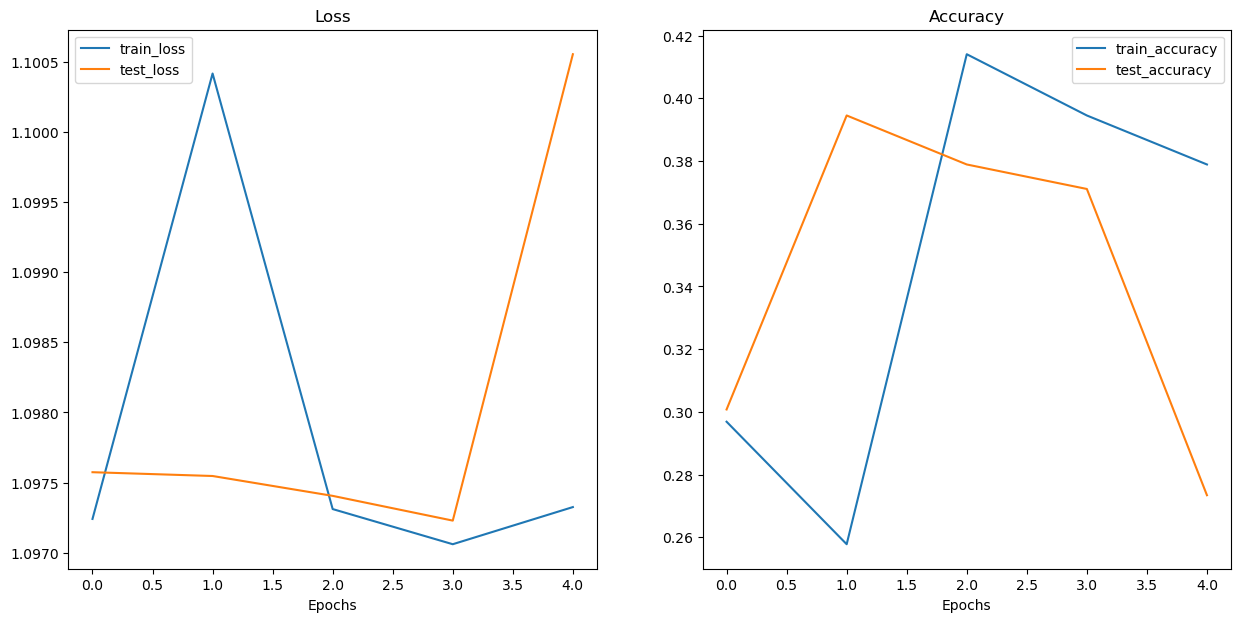

In [124]:
plot_loss_curves(train_results_5_epochs)

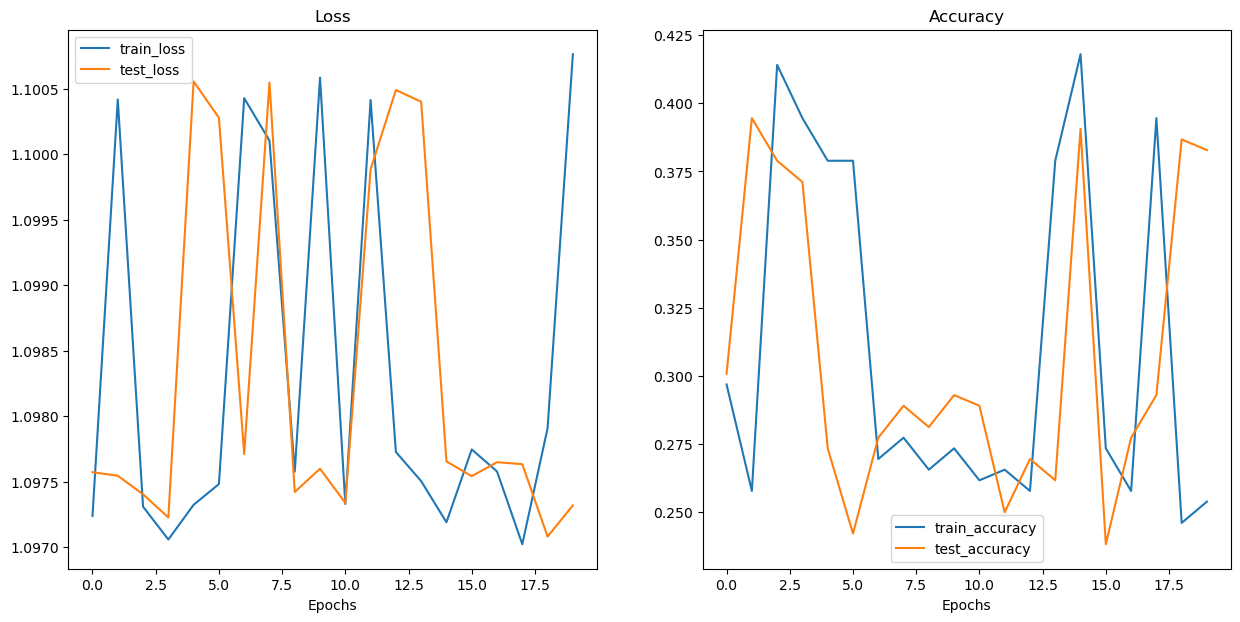

In [125]:
plot_loss_curves(train_results_20_epochs)

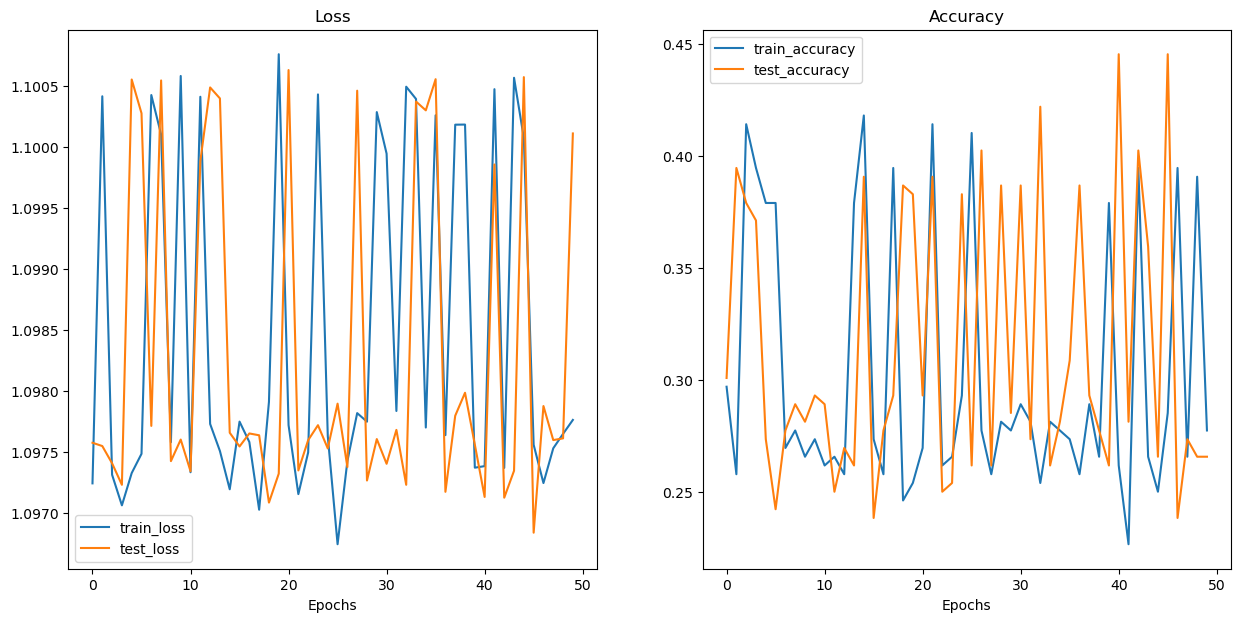

In [126]:
plot_loss_curves(train_results_50_epochs)